<a href="https://colab.research.google.com/github/AlirezaPNouri/Storytelling/blob/main/K_cluster_vs_threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.2 MB/s 
     |████████████████████████████████| 163 kB 47.9 MB/s 
     |████████████████████████████████| 6.6 MB 15.8 MB/s 


In [2]:
# needed packages
import requests
import numpy as np
import pandas as pd
import string
import pickle
import os
from numpy import median, array, exp
from sklearn.cluster import KMeans
import copy
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

In [3]:
#### Load the pre-traiend BERT model #####################
##########################################################
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')



Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [4]:
#constant variables
dataset_covid_link = 'https://raw.githubusercontent.com/AlirezaPNouri/Storytelling/main/datasets/short_parsed_covid_data.csv'
dataset_NYT_link = 'https://raw.githubusercontent.com/AlirezaPNouri/Storytelling/main/datasets/short_parsed_NYT_data.csv'
dataset_percentage = .6
MAX_DATA = 100
MAX_SENTENCE_LENGTH = 350
MIN_SENTENCE_LENGTH = 200
doc_list =[item for item in range(MAX_DATA)]
jump = 3 # jump size for gradient decent
MAX_FEATURE_SIZE = 20 # max size of the gradient descent vector
range_n_clusters = [2, 3, 4, 5, 6] #number of different clustering to compare the performance of the model over different clustering
threshold_cluster_overlapping = 0.7 # to consider two clsuters are similar
stopwords = ['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself','yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself','they','them','their','theirs','themselves','what','which','who','whom','this','that','these','those','am','is','are','was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an','the','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','between','into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how','all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can','will','just','don','should','now', 'of', 'within']


In [5]:
# download the dataset as a zip file from the git repo
def dataset_downloader(str_):
  """
  This function download a dataset
  Arguments:
    str_: the name of the dataset. It can be covid or NYT
  Returns:
    df: a pandas dataframe
  """
  if str_ == 'covid':
    url = dataset_NYT_link
  elif str_ == 'NYT':
    url = dataset_covid_link
  else:
    print('dataset is not choose correctly!')

  print('Downloading dataset...')
  res = requests.get(url, allow_redirects=True)
  with open('small_dataset_NYT.csv','wb') as file:
      file.write(res.content)
  print('Download is done!')
  df = pd.read_csv("/content/small_dataset_NYT.csv", header= None, skiprows=1)
  if str_ == 'NYT':
    df.columns = ['id', 'title', 'content', 'publish_time', 'author']
  elif str_ == 'covid':
    df.columns = ['id', 'title', 'content', 'author', 'publish_time']
  
  df = df.dropna(how='any', axis=0)
  print('dataset size after removing non-value cells is {}'.format(df.shape))
  # reduce the size of dataset to dataset_percentage*dataset.shape
  df = df.sample(frac=dataset_percentage)
  print('The new size of dataset is {} and the columns are {}'.format(df.shape, df.columns.values ))
  # remove the content that has less than MIN_SENTENCE_LENGTH words 
  df = df[df['content'].apply(lambda x : len(x.split(' ')))>=MIN_SENTENCE_LENGTH]

  # keep the first 500 words in content
  df['content'] = df['content'].apply(lambda x : ' '.join(x.split(' ')[:MAX_SENTENCE_LENGTH]))
  return df


In [6]:
def special_char_remover(str_):
  """
  This function removes any special characters from a text
  Arguments:
    str_: a string
  Returns:
    A string
  """
  return ' '.join(''.join(w for w in m if w.isalnum()) for m in str_.split(' '))

In [7]:
### create embedding vector for each token in each document
def bert_embedding_generator(df_):
  """
  Generate the embedding for a document
  Arguments:
    df_: a pandas dataframe 
  Returns:
    Embedding_dict: a dictionary of document indices and [embedding vectors, content]
  """
  Embedding_dict = dict()
  print('Start to generate the embedding vector for documents')
  c = 0
  for index, row in df_.iterrows():
    content_ = row['content']
    tmp_e = model(tf.constant(tokenizer.encode(content_))[None, :])[0][0]
    tmp_d = tokenizer.tokenize(content_)
    temp_dict = dict()
    temp_dict['cls'] = tmp_e[0]
    for emb, tok in zip(tmp_e[1:-1], tmp_d):
      temp_dict[tok] = emb
    temp_dict['sep'] = tmp_e[-1]
    Embedding_dict[row['id']] = temp_dict
    c +=1
  print('Embedding is done for {} documents.'.format(c))
  return Embedding_dict

In [8]:
#### Create a list of dataframe out of the dataset. Each dataframe belongs to a timestamp #############
#######################################################################################################
# use 10 days as time interval
def timestamps_generator(df_):
  """
  This function collect data related to each timestamp separately in a dataframe
  Arguments:
    df_: a pandas dataframe
  Returns:
    df_list: a list of all timestamps data [df_1, df_2, ...]
  """
  time_stamp = set()
  df_list= list()
  for index, row in df_.iterrows():
    time_stamp.add(row['publish_time'][0:4])
  for time_interval in time_stamp:
    new_df = df_[df_['publish_time'].str.slice(0, 4)== time_interval]
    if new_df.shape[0]>5: #minimum number of doc in a timestamp
      df_list.append(new_df)
  return df_list

In [9]:
def time_fixer(str_):
  """
  This function convert a date from x/x/xxxx to 0x0xxxxx
  Arguments:
    str_: a date in a string format
  Returns:
    a string without any / and all months and days are in two digit
  """
  t_slot = str_.split('/')
  t_slot[0] = t_slot[0] if len(t_slot[0]) == 2 else '0'+t_slot[0]
  t_slot[1] = t_slot[1] if len(t_slot[1]) == 2 else '0'+t_slot[1]
  return ''+t_slot[0]+t_slot[1]+t_slot[2]

In [10]:
def find_similarity(Embed_):
  """
  This function calculate the cosine similarity between each pair of words in a document and sort them as a new vector
  Arguments:
    Embed_: a dictionary of all doc and embedding seperated into their timestamps {timestamp1 {doc1{token1: embedding, token2: embedding}}}
  Returns:
    neighbor_ts_doc: a dictionary of all timestamps, docs and the neighbor similarity for each word
  """
  tmp_collector = dict()
  neighbor_ts_doc = dict()
  for ts_ in Embed_.keys():
    temp = Embed_[ts_]
    final_list = dict()
    for doc in temp.keys():
      if doc in tmp_collector.keys():
        final_list[doc] = tmp_collector[doc]
      else:
        neighbor_dict = dict()
        track_dict = dict()
        
        for f_word, f_emb in temp[doc].items():
          temp_list = list()
          
          for s_word, s_emb in temp[doc].items():
            if (s_word, f_word) in track_dict.keys():
              temp_list.append(track_dict[(s_word, f_word)])
            else:
              track_dict[(f_word, s_word)] = cosine_similarity([f_emb],[s_emb])[0][0]
              temp_list.append(track_dict[(f_word, s_word)])
          
          neighbor_dict[f_word] =sorted(temp_list, reverse=True)[1:] # ignore the cosine similarity between a word and itself

        final_list[doc] = neighbor_dict
        tmp_collector[doc] = neighbor_dict

      print('Document {} is done!'.format(doc))
    neighbor_ts_doc[ts_] = final_list
  return neighbor_ts_doc

In [11]:

#sigmoid function
def amplifier_function(vec_):
  """
  This function receives a vector and applies the curve below to reward the first part of the vector and to penalize the last part of the vector
  Arguments:
    vec_: a vector
  Results:
    g: a vector
  """
  z = array(vec_)
  z = z/np.linalg.norm(z)
  g = 1 / (1 + exp(-z))
  return g

In [12]:
def gradient_calculator(ns_dict, n_step, MAX_FEATURE_SIZE):
  """
  This function receives all the similarity neighbor for each word in all documents and apply gradient descent over them by the step
  Arguments:
    ns_dict: a dictinary of all neighbor similarity for all tokens
    n_step: the jump value for gradient discent
    MAX_FEATURE_SIZE: the maximum size for each feature victor
  Returns:
    final_dict: a dictionary of all gradient discent of tokens neighbor similarity
  """
  final_dict = dict()
  for ts_ in ns_dict.keys():
    gradient_descent_neighbors = dict()
    word_neighbor_similarity = ns_dict[ts_]
    for doc in word_neighbor_similarity.keys():
      temp_dict = dict()
      for word, embedding in word_neighbor_similarity[doc].items():
        vec_size = len(embedding)
        vec_size -= vec_size%n_step
        embedding = embedding[0:vec_size]
        new_list = [embedding[x:x+n_step] for x in range(0, vec_size, n_step)]
        tmp_list = list()
        for ele in new_list:
          m1,b1 = np.polyfit(np.arange(0, n_step), ele, 1)
          tmp_list.append(m1)
        temp_dict[word] = amplifier_function(tmp_list[0:MAX_FEATURE_SIZE])
      gradient_descent_neighbors[doc] = temp_dict
      print('Document {} is done!'.format(doc))
    final_dict[ts_] = gradient_descent_neighbors
  return final_dict

In [13]:

# clustering the tokens in each document. It creates differnt number of clustering

def cluster_maker(final_vec_):
  """
  This function generates clusters based on featur vectors
  Arguments:
    final_vec_: a dictionary of all gradient discent of tokens neighbor similarity
  Returns:
    total_clustering: a dictionary contains timestamps and clusters in each timestamp 
    total_centroid: a dictionart contains timestamps and centroids for each clusters
  """
  total_clustering = dict()
  total_centroid = dict()
  for ts_ in final_vec_.keys():
    gradient_descent_neighbors = final_vec_[ts_]
    all_clusters = dict()
    all_centroid = dict()
    for doc, featurs in gradient_descent_neighbors.items():
      clusters_per_doc = dict()
      centroids_per_doc = dict()
      for n_clusters in range_n_clusters:
        clusterer = KMeans(n_clusters=n_clusters, random_state=10, max_iter=100,)
        clusters_per_doc[n_clusters] = clusterer.fit_predict(list(featurs.values()))
        centroids_per_doc[n_clusters] = clusterer.cluster_centers_
      all_clusters[doc] = clusters_per_doc
      all_centroid[doc] = centroids_per_doc
      print('Document {} is done!'.format(doc))
    total_clustering[ts_] = all_clusters
    total_centroid[ts_] = all_centroid
  return total_clustering, total_centroid
    

In [14]:
def sorted_clustering(all_gradient_descent_neighbors,all_clusters_dict, all_centroids_dict):
  final_clustering_dict = dict()
  for ts_ in all_clusters_dict.keys():
    gradient_descent_neighbors = all_gradient_descent_neighbors[ts_]
    all_centroid = all_centroids_dict[ts_]
    all_clusters = all_clusters_dict[ts_]
    #create a total clusters sorted dictionary
    ## the structure of total_docs_clusters  is {doc0: {number_of_clusters { cluster_number: {token0: closeness_to_centroid, token1: closeness_to_centroid ...} }}}
    total_docs_clusters = dict()
    for doc in all_clusters.keys():
      temp_cluster = all_clusters[doc]
      dic_for_clustering = dict()
      for n_cluster in range_n_clusters:
        temp_dict = dict()
        for la in range(n_cluster):
          temp_list = dict()
          for label_, value_ in zip(temp_cluster[n_cluster],gradient_descent_neighbors[doc].items()):
            if label_ == la:
              temp_list[value_[0]] = np.sum(np.square(value_[1] - all_centroid[doc][n_cluster][la]))
          temp_dict[la]=temp_list
        dic_for_clustering[n_cluster] = temp_dict
      total_docs_clusters[doc] = dic_for_clustering
      print('Document {} is done!'.format(doc))
    final_clustering_dict[ts_] = total_docs_clusters
  return final_clustering_dict

In [15]:
def normalize_vec(vec, min_, max_):
  """
  # this function will receive a vector and the min and max of that vector and will return the normalized vec 
  """
  range_val = (max_ - min_)+0.0000001
  vec = [item/range_val for item in vec]
  min_vec = min(vec)
  vec = [item - min_vec for item in vec]
  return vec



def normalize_value(item, min_, max_):
  """
  # this function will receive a value of a vector, the min and the max of the vector and returns the normalized value
  """
  range_val = (max_ - min_)+0.0000001
  vec = (item-min_)/range_val
  return vec

In [16]:
def normalizer(total_docs_clustering_):
  """
    normalize the similarity in each cluster. It goes and find the min and max values in each clustering and make those similarity between [0,1] (the similarity here is euclidean distance between each token and the centroid)

  """
  all_total_docs_clusters = dict()
  for ts_ in total_docs_clustering_.keys():
    total_docs_clusters = total_docs_clustering_[ts_]
    for doc in total_docs_clusters.keys():
      temp_doc = total_docs_clusters[doc]
      for cluster_rank in temp_doc.keys():
        temp_clustering = temp_doc[cluster_rank]
        min_sim = 1
        max_sim = 0
        for ind in temp_clustering.keys():
          for ele, val_ in temp_clustering[ind].items():
            min_sim = min_sim if min_sim<val_ else val_
            max_sim = max_sim if val_<max_sim else val_ 

        for ins in temp_clustering.keys():
          for el in total_docs_clusters[doc][cluster_rank][ins].keys():
            total_docs_clusters[doc][cluster_rank][ins][el] = normalize_value(total_docs_clusters[doc][cluster_rank][ins][el], min_sim, max_sim)
      print('Document {} is done!'.format(doc))
    all_total_docs_clusters[ts_] = total_docs_clusters
  return all_total_docs_clusters

In [17]:
def stopword_remover(all_dict_):
  final_dict_w_stopword = dict()
  for ts_ in all_dict_.keys():
    total_docs_clusters = all_dict_[ts_]
    #remove stopwords
    total_docs_clusters_wo_stopwords = dict()
    for doc in total_docs_clusters.keys():
      temp_doc = {}
      for cluster_rank in total_docs_clusters[doc].keys():
        temp_clustering = {}
        for ins in total_docs_clusters[doc][cluster_rank].keys():
          temp_cluster = {}
          for items in total_docs_clusters[doc][cluster_rank][ins].items():
            if items[0] not in stopwords:
              temp_cluster[items[0]] = items[1]
          temp_clustering[ins] = temp_cluster
        temp_doc[cluster_rank] = temp_clustering
      total_docs_clusters_wo_stopwords[doc] = temp_doc
    final_dict_w_stopword[ts_] = total_docs_clusters_wo_stopwords
  return final_dict_w_stopword

In [18]:
# Jaccard index function
def jaccard_similarity(text1_list, text2_list):
  a = set(text1_list)
  b = set(text2_list)
  return len(a.intersection(b))/len(a.union(b))

In [19]:
def word_group_generator(all_clusters_):
  final_total_doc_word_group = dict()
  for ts_ in all_clusters_.keys():
    total_docs_clusters_wo_stopwords = all_clusters_[ts_]
    total_doc_word_groups = dict()
    for doc in total_docs_clusters_wo_stopwords.keys():
      docs_clusters = total_docs_clusters_wo_stopwords[doc]
      # print(docs_clusters)
      temp_list_word_groups = list()
      for cluster_num in list(docs_clusters.keys())[:-1]:
        for cluster in range(cluster_num):
          for next_cluster in range(cluster_num+1):
            cl1 = list()
            cl1_w_sim = dict()
            cl2 = list()
            cl2_w_sim = dict()
            joint_list = list()
            for item in docs_clusters[cluster_num][cluster].items():
              cl1.append(item[0])
              cl1_w_sim[item[0]] =  item[1]
            for another_item in docs_clusters[cluster_num+1][next_cluster].items():
              cl2.append(another_item[0])
              cl2_w_sim[another_item[0]] = another_item[1]
            # print(' ({}, {}, {}) --> '.format(cluster_num, cluster, next_cluster), jaccard_similarity(cl1, cl2))
            jac_val = jaccard_similarity(cl1, cl2)
            if jac_val > threshold_cluster_overlapping:
              jnt_list = list(set(cl1).intersection(cl2))
              dict_vocab = dict()
              for el in jnt_list:
                dict_vocab[el] = max(cl1_w_sim[el], cl2_w_sim[el])

              temp_list_word_groups.append([dict_vocab ,jac_val])
      

      total_doc_word_groups[doc] = temp_list_word_groups
      # the structure of total_doc_word_group is {doc0: [ [ {word1: normalized_normalized_distance_to_centroid, ....}, similarity between two clusters] [{word1: normalized_distance_to_centroid, ....}, similarity_between_two_clusters]... ], doc1: ...}
    final_total_doc_word_group[ts_] = total_doc_word_groups
  return final_total_doc_word_group

In [20]:
def distance_2_freq(all_clusters_):
  """
  change the distance to centroid to the frequency [0, 1] --> [10, 1] 
  """
  final_dict = dict()
  for ts_ in all_clusters_.keys():
    total_doc_word_groups_ = all_clusters_[ts_]
    #change the distance to centroid to the frequency [0, 1] --> [10, 1] 
    for doc in total_doc_word_groups_.keys():
      temp_list = list()
      for word_list in total_doc_word_groups_[doc]:
        temp_dict = dict()
        for ele in word_list[0].keys():
          temp_dict[ele] =int(9* (1-word_list[0][ele]))+1
        temp_list.append(temp_dict)
      total_doc_word_groups_[doc] = temp_list
    final_dict[ts_] = total_doc_word_groups_
  return final_dict
    # the new structure of total_doc_word_groups_ is {doc0: [{groupOnewords}, grouptwowords], doc1}   , grouponewords = {word1:frequency, word2:ferquency}

In [21]:
def bert_classifier_generator(total_doc_word_embedding):
  """
  doc_matrix is a dictionary of each doc and other doc similarity to this doc based on BERT cls vector             doc_embedding ={doc0: {1: int(9*euclidian_distance +1 ), 2:int(9*euclidian_distance +1 )}, doc1}  

  """
  total_dict_ = dict()
  for ts_ in total_doc_word_embedding.keys():
    doc_word_embedding = total_doc_word_embedding[ts_]
    doc_embedding = dict()
    for first_doc in doc_word_embedding.keys():
      temp_dict = dict()
      for second_doc in doc_word_embedding.keys(): 
        if first_doc != second_doc:
          # temp_dict[second_doc] =int(9*np.square(sum(doc_word_embedding[first_doc]['cls']-doc_word_embedding[second_doc]['cls']))+1)
          temp_dict[second_doc] =int(9*np.linalg.norm(doc_word_embedding[first_doc]['cls']-doc_word_embedding[second_doc]['cls'])+1)
      doc_embedding[first_doc] = temp_dict
      print('Document {} is done!'.format(first_doc) )
    total_dict_[ts_] = doc_embedding
  return total_dict_
    


In [22]:
def similarity_documents(all_dict_):
  """
    calculate the similarity between two documents by using jaccard index of all word groups in each cluster by considering the frequency of those words
    the structure of total_clustering_w_frequency is {doc0:[[word_groups0],[word_groups1], ...], doc1: }
  """
  total_dict_ = dict()
  for ts_ in all_dict_.keys():
    total_doc_word_groups_ = all_dict_[ts_]
    total_clustering_w_frequency = dict()
    for doc in total_doc_word_groups_.keys():
      list_word_cloud = list()
      for word_group in total_doc_word_groups_[doc]:
        temp_list = list()
        for word in word_group.items():
          for ind in range(1, word[1]+1):
            temp_list.append(word[0])
        list_word_cloud.append(temp_list)
      total_clustering_w_frequency[doc] = list_word_cloud
      print('document {} is done!'.format(doc))
    total_dict_[ts_] = total_clustering_w_frequency
  return total_dict_


In [23]:
def similar_doc(doc_one, doc_two):
  """
  #find similar documents
  """
  list_sim = list()
  for clu_1 in doc_one:
    total_jac = 0
    for clu_2 in doc_two:
      jac_val = jaccard_similarity(clu_1, clu_2)
      total_jac += jac_val
    # total_jac /= len(doc_two)
    list_sim.append(total_jac)
  return sum(list_sim)
  # return sum(list_sim)/(len(doc_one)*len(doc_two))   #with normalizing based on the number of word groups

In [24]:
def weight_matrix_generator(all_dict_):
  final_dict_ = dict()
  for ts_ in all_dict_.keys():
    total_clustering_w_frequency_ = all_dict_[ts_]
    #create a matrix of document similarity based on the jaccard index of the similar words in each word group in each document
    doc_matrix=dict()
    for first_doc in total_clustering_w_frequency_.keys():
      temp_dict = dict()
      for second_doc in total_clustering_w_frequency_.keys():
        if first_doc != second_doc:
          temp_dict[second_doc] = similar_doc(total_clustering_w_frequency_[first_doc], total_clustering_w_frequency_[second_doc])
      doc_matrix[first_doc] = temp_dict
      print('Document {} is done'.format(first_doc))
    
    #normalize the weight and invert it. if an index is high that means they are similar so the weight must be low

    for doc in doc_matrix.keys():
      min_ = 10000
      max_ = -10000
      for ele in doc_matrix[doc].items():
        min_ = min_ if min_<ele[1] else ele[1]
        max_ = max_ if max_> ele[1] else ele[1]
      for ele in doc_matrix[doc].keys():
        doc_matrix[doc][ele] = int(99*(1-normalize_value(doc_matrix[doc][ele], min_, max_))+1)

    final_dict_[ts_]= doc_matrix
  return final_dict_


In [25]:
# A*Search algorithm

from collections import deque

class Graph:

    def __init__(self,heuristic, adjacency_list, start_node, stop_node):
        self.adjacency_list = adjacency_list
        self.H = dict()
        self.start_node = start_node
        self.stop_node = stop_node
        self.heuristic = heuristic
        for ele in heuristic[stop_node]:
          self.H[ele[0]] = ele[1]
        # self.H = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1}
      
    # def get_neighbors(self, v):
    #     return self.adjacency_list[v]
    # # heuristic function with equal values for all nodes
    
    # def h(self, n):
    #   # H = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1}
    #   return self.H[n]
    def a_star_algorithm(self):

      # open_list is a list of nodes which have been visited, but who's neighbors
      # haven't all been inspected, starts off with the start node
      # closed_list is a list of nodes which have been visited
      # and who's neighbors have been inspected
      open_list = set([self.start_node])
      closed_list = set([])
      # g contains current distances from start_node to all other nodes
      # the default value (if it's not found in the map) is +infinity
      g = {}
      g[self.start_node] = 0
      # parents contains an adjacency map of all nodes
      parents = {}
      parents[self.start_node] = self.start_node
      while len(open_list) > 0:
          n = None
          # find a node with the lowest value of f() - evaluation function
          for v in open_list:
              if n == None or g[v] + self.H[v] < g[n] + self.H[n]:
              # if n == None or g[v] + self.H[v] < g[n] + self.H[n]:
                  n = v;
          if n == None:
              print('Path does not exist!')
              return None
          # if the current node is the stop_node
          # then we begin reconstructin the path from it to the start_node
          if n == self.stop_node:
              reconst_path = []
              while parents[n] != n:
                  reconst_path.append(n)
                  n = parents[n]
              reconst_path.append(self.start_node)
              reconst_path.reverse()
              print('Path found: {}'.format(reconst_path))
              return reconst_path
          # for all neighbors of the current node do
          for (m, weight) in self.adjacency_list[n]:
              # if the current node isn't in both open_list and closed_list
              # add it to open_list and note n as it's parent
              avr = 0
              sam = 0
              for t in self.heuristic[n]: 
                  avr += t[1]
                  if t[0] == m:
                    sam = t[1]
              if sam > avr/2:
                  continue
              if m not in open_list and m not in closed_list:
                  open_list.add(m)
                  parents[m] = n
                  g[m] = g[n] + weight
              # otherwise, check if it's quicker to first visit n, then m
              # and if it is, update parent data and g data
              # and if the node was in the closed_list, move it to open_list
              else:
                  if g[m] > g[n] + weight:
                      g[m] = g[n] + weight
                      parents[m] = n
                      if m in closed_list:
                          closed_list.remove(m)
                          open_list.add(m)
          # remove n from the open_list, and add it to closed_list
          # because all of his neighbors were inspected
          open_list.remove(n)
          closed_list.add(n)

      print('Path does not exist!')
      return None

In [26]:
def a_search(all_embedding, all_weight):
  result_dict = dict()
  for ts_ in all_embedding.keys():
    doc_embedding_ = all_embedding[ts_]
    doc_matrix_ = all_weight[ts_]
    start_ = list(doc_embedding_.keys())[0]
    end_ = list(doc_embedding_.keys())[-1]
    #create the adjacancy matrix from the euclidean distanse of the doc embedding
    #heuristic

    heuristic = dict()
    for first_doc in doc_embedding_.keys():
      temp_list = list()
      for second_doc in doc_embedding_.keys():
        if first_doc != second_doc:
          temp_list.append((second_doc, doc_embedding_[first_doc][second_doc]))
        else:
          temp_list.append((second_doc, 0))
      heuristic[first_doc] = temp_list
    # print('heuristic is ', heuristic)

    # the weights
    doc_weights = dict()
    for first_doc in doc_matrix_.keys():
      temp_dict = list()
      for second_doc in doc_matrix_.keys():
        if first_doc != second_doc:
          temp_dict.append((second_doc, doc_matrix_[first_doc][second_doc]))
      doc_weights[first_doc] = temp_dict
    # print('weights is ', doc_weights)
    graph1 = Graph(heuristic, doc_weights, start_, end_)
    result_dict[ts_] = graph1.a_star_algorithm()
    print('Timestamp {} is done!'.format(ts_))
  return result_dict

In [27]:
def merging_df(list_df_):
  new_df_list = list()
  for n in range(len(list_df_)-1):
    frames = [list_df_[n], list_df_[n+1]]
    new_df_list.append(pd.concat(frames))
  new_df_list.append(list_df_[n+1])
  return new_df_list

In [28]:
def get_df_size(list_of_df_):
  tmp_list = list()
  for df_ in list_of_df_:
    tmp_list.append(len(list(df_['id'])))
  return tmp_list

In [36]:
df = dataset_downloader('NYT')
print(df.shape)
df = df.iloc[0:120]
print(df.shape)
df['content'] = df['content'].apply( lambda x: special_char_remover(x)) # remove special characters
df['publish_time'] = df['publish_time'].apply(lambda x: time_fixer(x))
list_of_dfs = timestamps_generator(df)
print('before merging dfs: ' ,get_df_size(list_of_dfs))
list_of_timestamps = [list(x['id']) for x in list_of_dfs ]
list_of_dfs = merging_df(list_of_dfs)  # merging two coonsecuative df to each other and made a new one 
print('after merging dfs: ',get_df_size(list_of_dfs))

Download is done!
dataset size after removing non-value cells is (5713, 5)
The new size of dataset is (3428, 5) and the columns are ['id' 'title' 'content' 'publish_time' 'author']
(2210, 5)
(120, 5)
before merging dfs:  [7, 11, 14, 9, 6, 8, 6, 7, 7, 16, 7]
after merging dfs:  [18, 25, 23, 15, 14, 14, 13, 14, 23, 23, 7]


In [37]:
Embed_dict = dict() # {timestamp1 {doc1{(number_of_tokens+1, 768)}, doc2{}}, timestamp2{}}
for ts, data_ in zip(range(len(list_of_dfs)), list_of_dfs):
   Embed_dict[ts] = bert_embedding_generator(data_)

Start to generate the embedding vector for documents
Embedding is done for 18 documents.
Start to generate the embedding vector for documents
Embedding is done for 25 documents.
Start to generate the embedding vector for documents
Embedding is done for 23 documents.
Start to generate the embedding vector for documents
Embedding is done for 15 documents.
Start to generate the embedding vector for documents
Embedding is done for 14 documents.
Start to generate the embedding vector for documents
Embedding is done for 14 documents.
Start to generate the embedding vector for documents
Embedding is done for 13 documents.
Start to generate the embedding vector for documents
Embedding is done for 14 documents.
Start to generate the embedding vector for documents
Embedding is done for 23 documents.
Start to generate the embedding vector for documents
Embedding is done for 23 documents.
Start to generate the embedding vector for documents
Embedding is done for 7 documents.


In [38]:
final_vector = find_similarity(Embed_dict)

Document 504078 is done!
Document 57111 is done!
Document 159568 is done!
Document 60870 is done!
Document 118123 is done!
Document 23987 is done!
Document 524783 is done!
Document 707560 is done!
Document 737825 is done!
Document 23780 is done!
Document 633555 is done!
Document 51030 is done!
Document 51040 is done!
Document 763263 is done!
Document 69939 is done!
Document 608333 is done!
Document 769982 is done!
Document 644764 is done!
Document 707560 is done!
Document 737825 is done!
Document 23780 is done!
Document 633555 is done!
Document 51030 is done!
Document 51040 is done!
Document 763263 is done!
Document 69939 is done!
Document 608333 is done!
Document 769982 is done!
Document 644764 is done!
Document 753179 is done!
Document 712489 is done!
Document 50766 is done!
Document 521913 is done!
Document 552069 is done!
Document 495902 is done!
Document 707385 is done!
Document 51284 is done!
Document 51137 is done!
Document 695060 is done!
Document 190890 is done!
Document 60598

In [39]:
final_vector = gradient_calculator(final_vector, jump, MAX_FEATURE_SIZE)

Document 504078 is done!
Document 57111 is done!
Document 159568 is done!
Document 60870 is done!
Document 118123 is done!
Document 23987 is done!
Document 524783 is done!
Document 707560 is done!
Document 737825 is done!
Document 23780 is done!
Document 633555 is done!
Document 51030 is done!
Document 51040 is done!
Document 763263 is done!
Document 69939 is done!
Document 608333 is done!
Document 769982 is done!
Document 644764 is done!
Document 707560 is done!
Document 737825 is done!
Document 23780 is done!
Document 633555 is done!
Document 51030 is done!
Document 51040 is done!
Document 763263 is done!
Document 69939 is done!
Document 608333 is done!
Document 769982 is done!
Document 644764 is done!
Document 753179 is done!
Document 712489 is done!
Document 50766 is done!
Document 521913 is done!
Document 552069 is done!
Document 495902 is done!
Document 707385 is done!
Document 51284 is done!
Document 51137 is done!
Document 695060 is done!
Document 190890 is done!
Document 60598

In [ ]:
cluster_vs_thres = dict()
for k in range(4, 9):
  range_n_clusters = range(2,k)
  temp_dict = dict()
  for thres in [0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    threshold_cluster_overlapping = thres
    total_clustering, total_centroid = cluster_maker(final_vector)
    total_docs_clustering = sorted_clustering(final_vector, total_clustering, total_centroid)
    normalized_total_docs_clusters = normalizer(total_docs_clustering)
    total_docs_clusters_wo_stopwords = stopword_remover(normalized_total_docs_clusters)
    total_doc_word_groups = word_group_generator(total_docs_clusters_wo_stopwords)
    total_doc_word_groups = distance_2_freq(total_doc_word_groups)

    temp_dict[thres] = total_doc_word_groups
    print('thres: {} and cluster {} is done.'.format(thres, k))
  cluster_vs_thres[k] = temp_dict

In [49]:
print(cluster_vs_thres.keys())
print(cluster_vs_thres[4].keys())
print(cluster_vs_thres[4][0.1].keys())
print(cluster_vs_thres[4][0.1][0].keys())
print(cluster_vs_thres[4][0.1][0][504078])
print(len(cluster_vs_thres[4][0.1][0][504078]))

dict_keys([4, 5, 6, 7, 8])
dict_keys([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
dict_keys([504078, 57111, 159568, 60870, 118123, 23987, 524783, 707560, 737825, 23780, 633555, 51030, 51040, 763263, 69939, 608333, 769982, 644764])
[{'##eak': 8, '72': 1, '##25': 8, '##mic': 7, 'treatment': 5, 'aims': 7, 'records': 7, '85': 7, '36': 7, 'study': 5, 'results': 7, 'methods': 6, '##ing': 7, 'collected': 4, 'instrument': 7, '##and': 4, 'parameters': 8, 'since': 6, 'data': 8, 'conducted': 1, 'co': 9, '##c': 4, 'self': 6, 'levels': 6}, {'healthy': 6, 'sep': 4, 'activities': 6, 'associated': 3, '##2': 8, '##dm': 7, 'respectively': 6, 'among': 2, '##her': 8, '##al': 2, '##emi': 7, 'unchanged': 7, 'relatively': 2, '##ful': 7, '##care': 4, 'healthcare': 1, '##sp': 7, '##7': 4, '737': 6, 'compared': 4, 'documented': 8}, {'##ef': 8, '##ad': 9, '##3': 9, 'assess': 8, 'prep': 9, '##ed': 9, 'decreased': 8, 'tools': 8, '##fi': 8, 'deterioration': 7, '##r

In [73]:
final_vec = dict()
c = 0
for k in cluster_vs_thres.keys():
  temp_dict = dict()
  for t in cluster_vs_thres[k].keys():
    length_vec = list()
    for time_s in cluster_vs_thres[k][t].keys():
      for doc in cluster_vs_thres[k][t][time_s].keys():
        c +=1
        length_vec.append(len(cluster_vs_thres[k][t][time_s][doc]))
    temp_dict[t] = np.median(length_vec)
  final_vec[k] = temp_dict

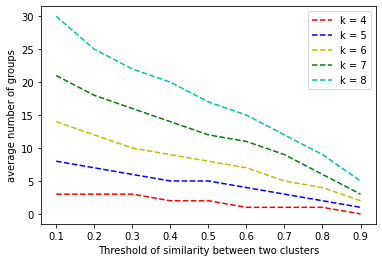

In [72]:
import matplotlib.pyplot as plt

vector_values = list(final_vec[4].values())[:-1]
plt.plot([0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], vector_values, 'r--', color='r', label='k = {}'.format(4))
vector_values = list(final_vec[5].values())[:-1]
plt.plot([0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], vector_values, 'r--', color='b', label='k = {}'.format(5))
vector_values = list(final_vec[6].values())[:-1]
plt.plot([0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], vector_values, 'r--', color='y', label='k = {}'.format(6))
vector_values = list(final_vec[7].values())[:-1]
plt.plot([0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], vector_values, 'r--', color='g', label='k = {}'.format(7))
vector_values = list(final_vec[8].values())[:-1]
plt.plot([0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], vector_values, 'r--', color='c', label='k = {}'.format(8))
plt.ylabel('average number of groups')
plt.xlabel('Threshold of similarity between two clusters')
plt.legend()
plt.show()